In [507]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from functools import reduce
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import shap
import numpy as np

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [701]:
#SET DIRECTORY NAME AND READ IN ALL DATA FILES
directory_name = 'Downloads/STWS_Hackathon_Data_2020/'

team_summary_20_df = pd.read_csv(directory_name + "Team Summary 2020.csv")
team_summary_19_df = pd.read_csv(directory_name + "Team Summary 2019.csv")
team_summary_18_df = pd.read_csv(directory_name + "Team Summary 2018.csv")

player_summary_20_df = pd.read_csv(directory_name + "Player Summary 2020.csv")
player_summary_19_df = pd.read_csv(directory_name + "Player Summary 2019.csv")
player_summary_18_df = pd.read_csv(directory_name + "Player Summary 2018.csv")

In [702]:
#READ IN BROWNLOW POINTS DATA
#https://afltables.com/afl/brownlow/brownlow20018.html
#https://afltables.com/afl/brownlow/brownlow2019.html
#https://afltables.com/afl/brownlow/brownlow2020.html
brownlow_18_df = pd.read_csv(directory_name + "Brownlow_Pts_2018.csv",encoding = "ISO-8859-1")
brownlow_19_df = pd.read_csv(directory_name + "Brownlow_Pts_2019.csv",encoding = "ISO-8859-1")
brownlow_20_df = pd.read_csv(directory_name + "Brownlow_Pts_2020.csv",encoding = "ISO-8859-1")

In [717]:
##ALL FUNCTIONS FOR MODELLING AND TESTING

def clean_brownlow_df(brownlow_df,season):
    
    brownlow_df = brownlow_df.copy()
    brownlow_df.columns = [c.strip() for c in brownlow_df.columns]
    brownlow_df = brownlow_df.iloc[:,0:-4]
    brownlow_df = brownlow_df.melt(id_vars=['Player','TM','V','GM'])
    brownlow_df.rename(columns={'variable':"GROUP_ROUND_NO",'value':'BROWNIE_PTS'},inplace=True)
    brownlow_df['SEASON_ID'] = season
    brownlow_df.loc[brownlow_df['BROWNIE_PTS'].isna(),'BROWNIE_PTS'] = '0'
    brownlow_df['BROWNIE_PTS'] = [b.replace('-','0') for b in brownlow_df['BROWNIE_PTS']]
    brownlow_df['FULLNAME'] = [p.split(',')[1].strip() + ' ' + p.split(',')[0].strip() if len(p.split(',')) > 1 else '' for p in brownlow_df['Player']]    
    brownlow_df = brownlow_df.loc[:,'GROUP_ROUND_NO':'FULLNAME']
    brownlow_df=brownlow_df.astype({'GROUP_ROUND_NO': 'int64','BROWNIE_PTS': 'int64'})
    
    return brownlow_df

def create_player_modelling_df(brownlow_df,player_summary_df):
    
    brownlow_df = brownlow_df.copy()
    player_summary_df = player_summary_df.copy()
    player_brownlow_df = player_summary_df.join(brownlow_df.set_index(['SEASON_ID','GROUP_ROUND_NO','FULLNAME']),on=['SEASON_ID','GROUP_ROUND_NO','FULLNAME'],how='left')
    player_brownlow_df.loc[player_brownlow_df['BROWNIE_PTS'].isna(),'BROWNIE_PTS'] = 0
    player_stats_df = player_brownlow_df.groupby(['SEASON_ID','MATCH_ID','GROUP_ROUND_NO','FULLNAME']).sum().loc[:,'BALL_UP_CLEARANCE':'TURNOVER_UNFORCED_GIVEAWAY']
    player_stats_df.drop(['RATING','RANKING_PTS','RATING_BALL_USE','RATING_BALL_WINNING','RATING_DEFENCE','RATING_FIELD_KICKS','RATING_HITOUTS','RATING_PRESSURE','RATING_SHOTS'],axis=1,inplace=True)
    player_outcomes_df = player_brownlow_df.groupby(['SEASON_ID','MATCH_ID','GROUP_ROUND_NO','FULLNAME']).mean().loc[:,'BROWNIE_PTS']
    player_comb_df = player_stats_df.join(player_outcomes_df)
    
    return player_comb_df

def create_player_rating_df(brownlow_df,player_summary_df):
    
    brownlow_df = brownlow_df.copy()
    player_summary_df = player_summary_df.copy()
    player_brownlow_df = player_summary_df.join(brownlow_df.set_index(['SEASON_ID','GROUP_ROUND_NO','FULLNAME']),on=['SEASON_ID','GROUP_ROUND_NO','FULLNAME'],how='left')
    player_brownlow_df.loc[player_brownlow_df['BROWNIE_PTS'].isna(),'BROWNIE_PTS'] = 0
    player_stats_df = player_brownlow_df.groupby(['SEASON_ID','MATCH_ID','GROUP_ROUND_NO','FULLNAME']).sum().loc[:,'BALL_UP_CLEARANCE':'TURNOVER_UNFORCED_GIVEAWAY']
    player_stats_df = player_stats_df.loc[:,['RATING_BALL_USE','RATING_BALL_WINNING','RATING_DEFENCE','RATING_FIELD_KICKS','RATING_HITOUTS','RATING_PRESSURE','RATING_SHOTS']]
    player_outcomes_df = player_brownlow_df.groupby(['SEASON_ID','MATCH_ID','GROUP_ROUND_NO','FULLNAME']).mean().loc[:,'BROWNIE_PTS']
    player_comb_df = player_stats_df.join(player_outcomes_df)
    
    return player_comb_df

def create_team_modelling_df(team_summary_df):
    
    team_summary_df = team_summary_df.copy()
    match_stats_df = team_summary_df.groupby(['MATCH_ID','SQUAD_NAME','PERIOD']).sum().loc[:,'BALL_UP':]
    match_stats_df.drop(['SCORING_SHOTS','GOAL','GOAL_ASSIST','SHOT_AT_GOAL','BEHIND_ASSIST','BEHIND_INC_RUSH','SCORE_ASSIST',
                         'EXPECTED_SCORE','IN50_TARGET_PLAY_SCORE','IN50_TARGET_TEAM_SCORE','LONG_DOWN_LINE_SCORE','TURNOVER_FORCED_PTS',
                         'BU_GOAL_LAUNCH','CB_GOAL_LAUNCH','D50_REB_GOAL','KI_GOAL_LAUNCH','PG_GOAL_LAUNCH','ST_GOAL_LAUNCH','TI_GOAL_LAUNCH',
                         'BU_BEHIND_LAUNCH','CB_BEHIND_LAUNCH','KI_BEHIND_LAUNCH','PG_BEHIND_LAUNCH','ST_BEHIND_LAUNCH','TI_BEHIND_LAUNCH',
                         'BU_SCORE_LAUNCH','CB_SCORE_LAUNCH','D50_REB_SCORE','KI_SCORE_LAUNCH','PG_SCORE_LAUNCH','ST_SCORE_LAUNCH','TI_SCORE_LAUNCH',                         
                         'SCORE','RATING','RANKING_PTS','RATING_BALL_USE','RATING_BALL_WINNING','RATING_DEFENCE','RATING_FIELD_KICKS','RATING_HITOUTS',
                         'RATING_PRESSURE','RATING_SHOTS'],axis=1,inplace=True)
    match_outcomes_df = team_summary_df.groupby(['MATCH_ID','SQUAD_NAME','PERIOD']).mean().loc[:,'SQUAD_MARGIN':'MARGIN']
    team_comb_df = match_stats_df.join(match_outcomes_df)
    team_comb_df.drop('SQUAD_MARGIN',axis=1,inplace=True)
    
    return team_comb_df

def create_team_rating_df(team_summary_df):
    
    team_summary_df = team_summary_df.copy()
    match_stats_df = team_summary_df.groupby(['MATCH_ID','SQUAD_NAME','PERIOD']).sum().loc[:,'BALL_UP':]
    match_stats_df = match_stats_df.loc[:,['RATING_BALL_USE','RATING_BALL_WINNING','RATING_DEFENCE','RATING_FIELD_KICKS','RATING_HITOUTS','RATING_PRESSURE','RATING_SHOTS']]
    match_outcomes_df = team_summary_df.groupby(['MATCH_ID','SQUAD_NAME','PERIOD']).mean().loc[:,'SQUAD_MARGIN':'MARGIN']
    team_comb_df = match_stats_df.join(match_outcomes_df)
    team_comb_df.drop('SQUAD_MARGIN',axis=1,inplace=True)
    
    return team_comb_df

def split_scale_dataset(modelling_df):
    
    modelling_df = modelling_df.copy()
    seed = 23
    test_size = 0.1
    X_train, X_test, y_train, y_test = train_test_split(modelling_df.iloc[:,:-1], modelling_df.iloc[:,-1], test_size=test_size, random_state=seed)
    
    s_scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(s_scaler.transform(X_train))
    X_test_scaled = pd.DataFrame(s_scaler.transform(X_test))
    
    X_train_scaled.index = X_train.index 
    X_test_scaled.index = X_test.index
    
    cols = ['f' + str(x) for x in X_train_scaled.columns]
    X_train_scaled.columns = cols
    X_test_scaled.columns = cols
    
    return X_train_scaled,X_test_scaled,y_train,y_test

def grid_search_cv_model(X_train,y_train):
    
    X_train = X_train.copy()
    y_train = y_train.copy()
    
    model = XGBRegressor()

    param_grid = {
        'n_estimators': [400],
        'colsample_bytree': [0.7],
        'max_depth': [10],
        'reg_alpha': [1.1, 1.3],
        'gamma': [0,1],
        'reg_lambda': [1.1, 1.3],
        'subsample': [0.7, 0.9]
    }

    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=5, 
        n_jobs=4, 
        scoring='r2',
        verbose=2
    )

    model = gs.fit(X_train, y_train)
    
    return model

def get_testing_df(X_test,y_test,model):
    
    X_test = X_test.copy()
    y_test = y_test.copy()
    X_test_mod = X_test.copy()
    
    if type(X_full_18) != np.ndarray:
        X_test_mod.columns = model.best_estimator_.get_booster().feature_names
    
    preds = model.predict(X_test)
    testing_df = pd.DataFrame({'preds':preds,'actuals':y_test})
    
    return testing_df

def get_feature_imp_df(modelling_df,model):
    
    modelling_df = modelling_df.copy()
    
    feature_imp_df = pd.DataFrame({'Feature':modelling_df.iloc[:,:-1].columns,'Gain':model.best_estimator_.feature_importances_})
    feature_imp_df = feature_imp_df.sort_values(['Gain'],ascending=False)
    
    return feature_imp_df

def get_shap_imp_df(modelling_df,X_train,model):
    
    modelling_df = modelling_df.copy()
    X_train = X_train.copy()
    
    X_df = pd.DataFrame(X_train)
    X_df.columns = modelling_df.iloc[:,:-1].columns
    explainer = shap.TreeExplainer(model.best_estimator_)
    shap_values = explainer.shap_values(X_df)
    
    return shap_values, X_df

In [ ]:
#####################################
#####################################
############PLAYER MODELS############
#####################################
#####################################

In [704]:
#Clean Brownlow data to get into correct format to join to player data
brownlow_18_df = clean_brownlow_df(brownlow_18_df,2018)
brownlow_19_df = clean_brownlow_df(brownlow_19_df,2019)   
brownlow_20_df = clean_brownlow_df(brownlow_20_df,2020)   
brownlow_18_df.head()

,GROUP_ROUND_NO,BROWNIE_PTS,SEASON_ID,FULLNAME
0,1,3,2018,Tom Mitchell
1,1,0,2018,Steele Sidebottom
2,1,0,2018,Angus Brayshaw
3,1,0,2018,Max Gawn
4,1,2,2018,Patrick Cripps


In [705]:
#Join Brownlow data and player data and choose relevant columns to create modelling dataset
player_comb_18_df = create_player_modelling_df(brownlow_18_df,player_summary_18_df)
player_comb_19_df = create_player_modelling_df(brownlow_19_df,player_summary_19_df)
player_comb_20_df = create_player_modelling_df(brownlow_20_df,player_summary_20_df)
player_comb_18_df.head()

BALL_UP_CLEARANCE  \
SEASON_ID MATCH_ID  GROUP_ROUND_NO FULLNAME                            
2018      104110101 24             Alex Rance                      0   
                                   Bachar Houli                    0   
                                   Ben McEvoy                      0   
                                   Ben Stratton                    0   
                                   Blake Hardwick                  1   

                                                   BALL_UP_FIRST_POSSESSION  \
SEASON_ID MATCH_ID  GROUP_ROUND_NO FULLNAME                                   
2018      104110101 24             Alex Rance                             0   
                                   Bachar Houli                           0   
                                   Ben McEvoy                             0   
                                   Ben Stratton                           0   
                                   Blake Hardwick                         1   

                                                   BALL_UP_HITOUT  \
SEASON_ID MATCH_ID  GROUP_ROUND_NO FULLNAME                         
2018      104110101 24             Alex Rance                   0   
                                   Bachar Houli                 0   
                                   Ben McEvoy                   4   
                                   Ben Stratton                 0   
                                   Blake Hardwick               0   

                                                   BALL_UP_HITOUT_SHARKED  \
SEASON_ID MATCH_ID  GROUP_ROUND_NO FULLNAME                                 
2018      104110101 24             Alex Rance                           0   
                                   Bachar Houli                         0   
                                   Ben McEvoy                           0   
                                   Ben Stratton                         0   
                                   Blake Hardwick                       0   

                                                   BAULK  BAULKED  BEHIND  \
SEASON_ID MATCH_ID  GROUP_ROUND_NO FULLNAME                                 
2018      104110101 24             Alex Rance          0        0       0   
                                   Bachar Houli        0        0       0   
                                   Ben McEvoy          0        0       0   
                                   Ben Stratton        0        0       0   
                                   Blake Hardwick      0        0       0   

                                                   BEHIND_ASSIST  BLOCK  \
SEASON_ID MATCH_ID  GROUP_ROUND_NO FULLNAME                               
2018      104110101 24             Alex Rance                  0      1   
                                   Bachar Houli                0      0   
                                   Ben McEvoy                  0      0   
                                   Ben Stratton                0      0   
                                   Blake Hardwick              0      0   

                                                   BROKEN_TACKLE  ...  \
SEASON_ID MATCH_ID  GROUP_ROUND_NO FULLNAME                       ...   
2018      104110101 24             Alex Rance                  0  ...   
                                   Bachar Houli                0  ...   
                                   Ben McEvoy                  0  ...   
                                   Ben Stratton                0  ...   
                                   Blake Hardwick              0  ...   

                                                   METRES_GAINED_EFF  \
SEASON_ID MATCH_ID  GROUP_ROUND_NO FULLNAME                            
2018      104110101 24             Alex Rance                    243   
                                   Bachar Houli                  247   
                                   Ben McEvoy                     10   
                              

In [710]:
#Split and scale datasets
X_train_18, X_test_18, y_train_18, y_test_18 = split_scale_dataset(player_comb_18_df)
X_train_19, X_test_19, y_train_19, y_test_19 = split_scale_dataset(player_comb_19_df)
X_train_20, X_test_20, y_train_20, y_test_20 = split_scale_dataset(player_comb_20_df)

In [491]:
#Fit Model for 2018 Season
player_model_18 = grid_search_cv_model(X_train_18,y_train_18)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  8.3min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 20.2min finished


[19:54:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.16115417124542003


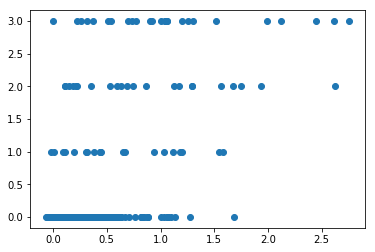

,Feature,Gain
115,POSSESSION,0.047198
29,DISPOSAL,0.026475
130,SCORE,0.025845
50,GOAL,0.018002
5,BAULKED,0.013890
124,RETAIN_DISPOSAL,0.012047
128,RUNDOWN_TACKLE,0.009692
202,CONTEST_TARGET,0.009308
127,RUCK_HARD_BALL_GET,0.009205
63,HIT_OUT_TO_ADVANTAGE,0.008929


In [711]:
##Check Results and Feature Importance
#Scatter plot of predictions vs actuals
testing_df = get_testing_df(X_test_18,y_test_18,player_model_18)
plt.scatter(testing_df['preds'],testing_df['actuals'])
#Check MAE
print(mean_absolute_error(testing_df['preds'],testing_df['actuals']))
plt.show()

#Top 10 Features
feature_imp_df = get_feature_imp_df(player_comb_18_df,player_model_18)
feature_imp_df[0:10]

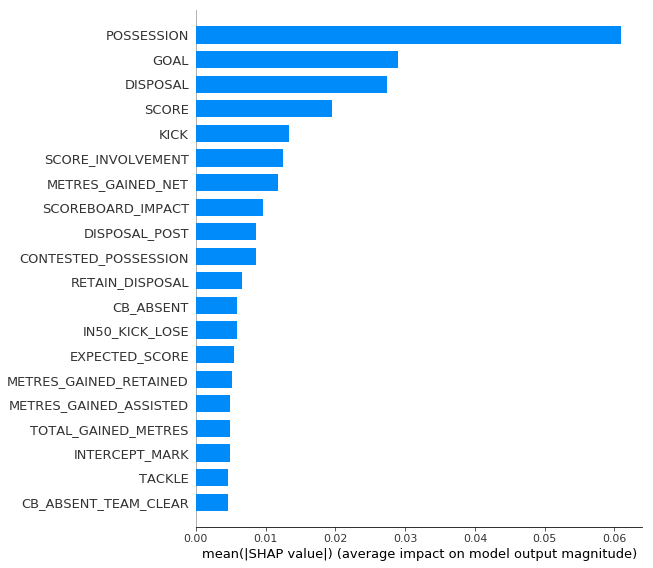

In [712]:
# explain the model's predictions using SHAP
shap_values, X_df = get_shap_imp_df(player_comb_18_df,X_train_18,player_model_18)
shap.summary_plot(shap_values, X_df, plot_type="bar")

In [500]:
#Fit Model for 2019 Season
player_model_19 = grid_search_cv_model(X_train_19,y_train_19)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  8.2min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 19.5min finished


[20:37:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.1436354532330803


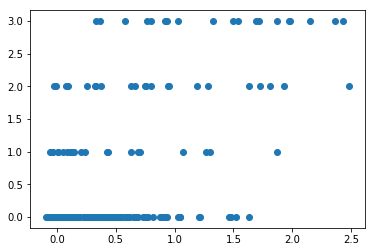

,Feature,Gain
29,DISPOSAL,0.040987
50,GOAL,0.025618
115,POSSESSION,0.023342
130,SCORE,0.016665
167,CENTRE_BOUNCE_VERSUS,0.015949
168,RUCK_CONTEST,0.015054
117,RE50_RESULT_OPP_UP,0.011049
62,HIT_OUT_SHARKED,0.010471
163,CB_ABSENT_TEAM_CLEAR,0.009601
136,SHORT_KICK,0.009042


In [713]:
##Check Results and Feature Importance
#Scatter plot of predictions vs actuals
testing_df = get_testing_df(X_test_19,y_test_19,player_model_19)
plt.scatter(testing_df['preds'],testing_df['actuals'])
#Check MAE
print(mean_absolute_error(testing_df['preds'],testing_df['actuals']))
plt.show()

#Top 10 Features
feature_imp_df = get_feature_imp_df(player_comb_19_df,player_model_19)
feature_imp_df[0:10]

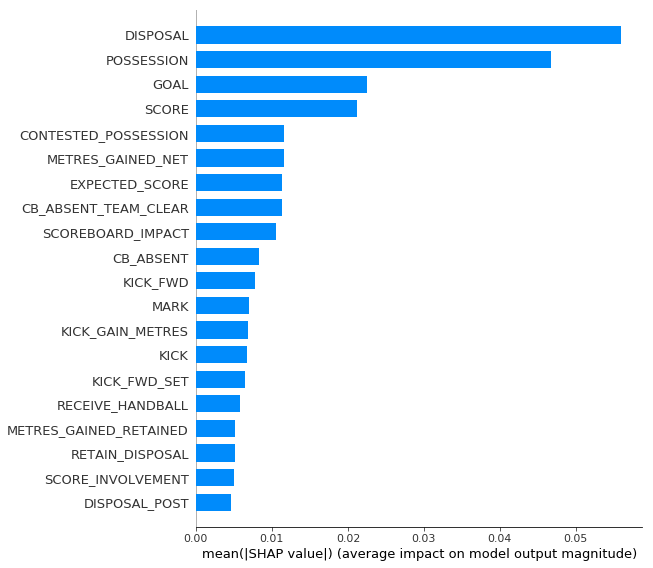

In [714]:
# explain the model's predictions using SHAP
shap_values, X_df = get_shap_imp_df(player_comb_19_df,X_train_19,player_model_19)
shap.summary_plot(shap_values, X_df, plot_type="bar")

In [502]:
#Fit Model for 2018 Season
player_model_20 = grid_search_cv_model(X_train_20,y_train_20)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 15.8min finished


[20:54:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.14146250586690273


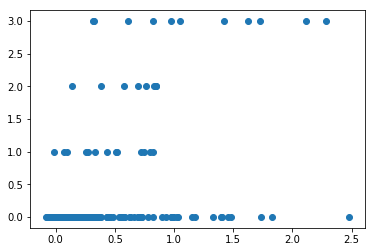

,Feature,Gain
115,POSSESSION,0.046526
50,GOAL,0.017718
124,RETAIN_DISPOSAL,0.017102
130,SCORE,0.015805
103,LOOSE_BALL_GET_PRE,0.011896
13,CB_HITOUT_TO_ADVANTAGE,0.011795
25,CONTESTED_POSSESSION,0.011549
82,INTERCEPT_FREE,0.011510
167,CENTRE_BOUNCE_VERSUS,0.010081
134,SCOREBOARD_IMPACT,0.009594


In [715]:
##Check Results and Feature Importance
#Scatter plot of predictions vs actuals
testing_df = get_testing_df(X_test_20,y_test_20,player_model_20)
plt.scatter(testing_df['preds'],testing_df['actuals'])
#Check MAE
print(mean_absolute_error(testing_df['preds'],testing_df['actuals']))
plt.show()

#Top 10 Features
feature_imp_df = get_feature_imp_df(player_comb_20_df,player_model_20)
feature_imp_df[0:10]

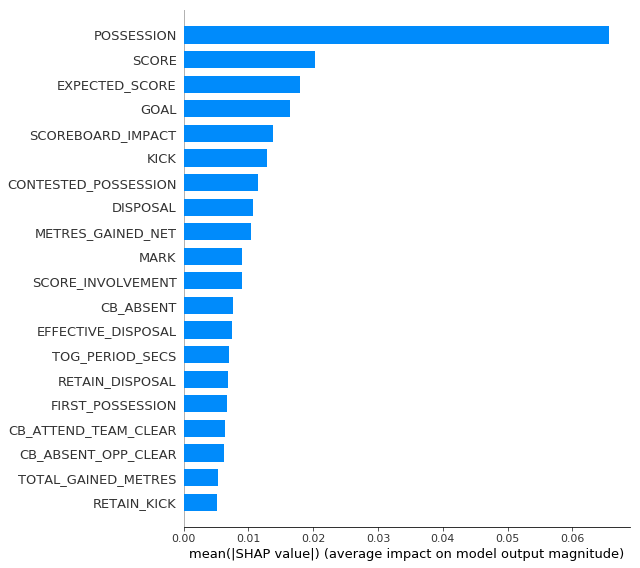

In [716]:
# explain the model's predictions using SHAP
shap_values, X_df = get_shap_imp_df(player_comb_20_df,X_train_20,player_model_20)
shap.summary_plot(shap_values, X_df, plot_type="bar")

In [718]:
#Get full predictions to write to file
X_full_18 = player_comb_18_df.iloc[:,:-1].values
y_full_18 = player_comb_18_df.iloc[:,-1].values
X_full_19 = player_comb_19_df.iloc[:,:-1].values
y_full_19 = player_comb_19_df.iloc[:,-1].values
X_full_20 = player_comb_20_df.iloc[:,:-1].values
y_full_20 = player_comb_20_df.iloc[:,-1].values

full_df_18 = get_testing_df(X_full_18,y_full_18,player_model_18)
full_df_19 = get_testing_df(X_full_19,y_full_19,player_model_19)
full_df_20 = get_testing_df(X_full_20,y_full_20,player_model_20)

full_df_18.index = player_comb_18_df.index
full_df_19.index = player_comb_19_df.index
full_df_20.index = player_comb_20_df.index

full_df_18.to_csv("AFL-2020-Hackathon/afl_player_preds_2018.csv")
full_df_19.to_csv("AFL-2020-Hackathon/afl_player_preds_2019.csv")
full_df_20.to_csv("AFL-2020-Hackathon/afl_player_preds_2020.csv")

In [719]:
#Write Shap values to file
shap_values_18, X_df_18 = get_shap_imp_df(player_comb_18_df,X_train_18,player_model_18)
shap_values_19, X_df_19 = get_shap_imp_df(player_comb_19_df,X_train_19,player_model_19)
shap_values_20, X_df_20 = get_shap_imp_df(player_comb_20_df,X_train_20,player_model_20)

shap_df_18 = pd.DataFrame(shap_values_18, columns=player_comb_18_df.columns[:-1], index=X_train_18.index)
shap_df_19 = pd.DataFrame(shap_values_19, columns=player_comb_19_df.columns[:-1], index=X_train_19.index)
shap_df_20 = pd.DataFrame(shap_values_20, columns=player_comb_20_df.columns[:-1], index=X_train_20.index)

shap_df_18.to_csv("AFL-2020-Hackathon/players_shap_18.csv")
shap_df_19.to_csv("AFL-2020-Hackathon/players_shap_19.csv")
shap_df_20.to_csv("AFL-2020-Hackathon/players_shap_20.csv")

In [ ]:
#########################################################################
#########################################################################
############PLAYER MODELS (CHAMPION RATINGS ONLY)########################
#########################################################################
#########################################################################

In [556]:
#Join Brownlow data and player data and choose only champion rating columns to create modelling dataset
player_comb_ratings_18_df = create_player_rating_df(brownlow_18_df,player_summary_18_df)
player_comb_ratings_19_df = create_player_rating_df(brownlow_19_df,player_summary_19_df)
player_comb_ratings_20_df = create_player_rating_df(brownlow_20_df,player_summary_20_df)
player_comb_ratings_18_df.head()

RATING_BALL_USE  \
SEASON_ID MATCH_ID  GROUP_ROUND_NO FULLNAME                          
2018      104110101 24             Alex Rance                  1.3   
                                   Bachar Houli               -0.6   
                                   Ben McEvoy                 -1.2   
                                   Ben Stratton               -3.2   
                                   Blake Hardwick             -1.9   

                                                   RATING_BALL_WINNING  \
SEASON_ID MATCH_ID  GROUP_ROUND_NO FULLNAME                              
2018      104110101 24             Alex Rance                      5.2   
                                   Bachar Houli                    5.0   
                                   Ben McEvoy                      5.3   
                                   Ben Stratton                    8.1   
                                   Blake Hardwick                  8.0   

                                                   RATING_DEFENCE  \
SEASON_ID MATCH_ID  GROUP_ROUND_NO FULLNAME                         
2018      104110101 24             Alex Rance                 3.2   
                                   Bachar Houli               2.6   
                                   Ben McEvoy                 3.5   
                                   Ben Stratton               6.2   
                                   Blake Hardwick             4.0   

                                                   RATING_FIELD_KICKS  \
SEASON_ID MATCH_ID  GROUP_ROUND_NO FULLNAME                             
2018      104110101 24             Alex Rance                     0.7   
                                   Bachar Houli                  -0.2   
                                   Ben McEvoy                    -1.1   
                                   Ben Stratton                  -2.2   
                                   Blake Hardwick                -1.7   

                                                   RATING_HITOUTS  \
SEASON_ID MATCH_ID  GROUP_ROUND_NO FULLNAME                         
2018      104110101 24             Alex Rance                 0.0   
                                   Bachar Houli               0.0   
                                   Ben McEvoy                 6.9   
                                   Ben Stratton               0.0   
                                   Blake Hardwick             0.0   

                                                   RATING_PRESSURE  \
SEASON_ID MATCH_ID  GROUP_ROUND_NO FULLNAME                          
2018      104110101 24             Alex Rance                  0.8   
                                   Bachar Houli                2.3   
                                   Ben McEvoy                  0.5   
                                   Ben Stratton                0.4   
                                   Blake Hardwick              0.5   

                                                   RATING_SHOTS  BROWNIE_PTS  
SEASON_ID MATCH_ID  GROUP_ROUND_NO FULLNAME                                   
2018      104110101 24             Alex Rance               0.0          0.0  
                                   Bachar Houli             0.0          0.0  
                                   Ben McEvoy               0.0          0.0  
                                   Ben Stratton             0.0          0.0  
                                   Blake Hardwick           0.0          0.0

In [557]:
#Split and scale datasets
X_train_ratings_18, X_test_ratings_18, y_train_ratings_18, y_test_ratings_18 = split_scale_dataset(player_comb_ratings_18_df)
X_train_ratings_19, X_test_ratings_19, y_train_ratings_19, y_test_ratings_19 = split_scale_dataset(player_comb_ratings_19_df)
X_train_ratings_20, X_test_ratings_20, y_train_ratings_20, y_test_ratings_20 = split_scale_dataset(player_comb_ratings_20_df)

In [558]:
#Fit Model for 2018 Season
player_ratings_model_18 = grid_search_cv_model(X_train_ratings_18,y_train_ratings_18)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   37.4s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  1.4min finished


[21:56:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.2082193048607505


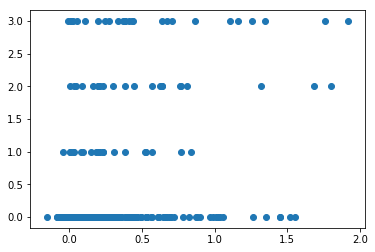

,Feature,Gain
1,RATING_BALL_WINNING,0.207923
0,RATING_BALL_USE,0.163765
6,RATING_SHOTS,0.143162
5,RATING_PRESSURE,0.137031
3,RATING_FIELD_KICKS,0.126465
2,RATING_DEFENCE,0.124572
4,RATING_HITOUTS,0.097082


In [559]:
##Check Results and Feature Importance
#Scatter plot of predictions vs actuals
testing_df = get_testing_df(X_test_ratings_18,y_test_ratings_18,player_ratings_model_18)
plt.scatter(testing_df['preds'],testing_df['actuals'])
#Check MAE
print(mean_absolute_error(testing_df['preds'],testing_df['actuals']))
plt.show()

#Top 10 Features
feature_imp_df = get_feature_imp_df(player_comb_ratings_18_df,player_ratings_model_18)
feature_imp_df[0:10]

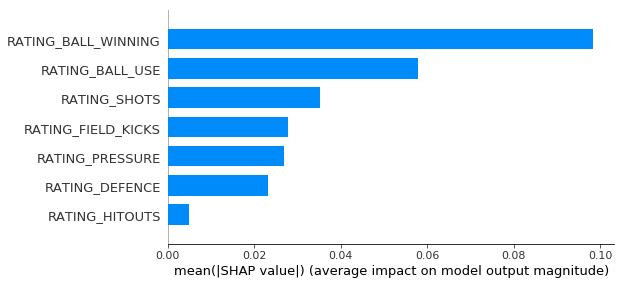

In [560]:
# explain the model's predictions using SHAP
shap_values, X_df = get_shap_imp_df(player_comb_ratings_18_df,X_train_ratings_18,player_ratings_model_18)
shap.summary_plot(shap_values, X_df, plot_type="bar")

In [561]:
#Fit Ratings Model for 2019 Season
player_ratings_model_19 = grid_search_cv_model(X_train_ratings_19,y_train_ratings_19)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   35.9s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  1.3min finished


[21:59:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.19360361854278949


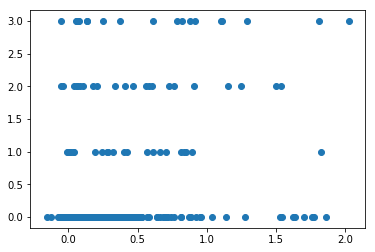

,Feature,Gain
1,RATING_BALL_WINNING,0.222354
0,RATING_BALL_USE,0.163396
6,RATING_SHOTS,0.137099
5,RATING_PRESSURE,0.134561
2,RATING_DEFENCE,0.127113
3,RATING_FIELD_KICKS,0.121728
4,RATING_HITOUTS,0.093748


In [562]:
##Check Results and Feature Importance
#Scatter plot of predictions vs actuals
testing_df = get_testing_df(X_test_ratings_19,y_test_ratings_19,player_ratings_model_19)
plt.scatter(testing_df['preds'],testing_df['actuals'])
#Check MAE
print(mean_absolute_error(testing_df['preds'],testing_df['actuals']))
plt.show()

#Top 10 Features
feature_imp_df = get_feature_imp_df(player_comb_ratings_19_df,player_ratings_model_19)
feature_imp_df[0:10]

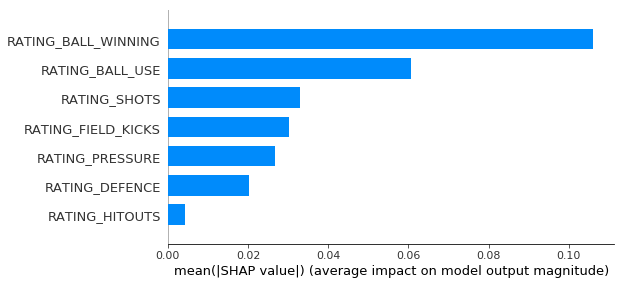

In [563]:
# explain the model's predictions using SHAP
shap_values, X_df = get_shap_imp_df(player_comb_ratings_19_df,X_train_ratings_19,player_ratings_model_19)
shap.summary_plot(shap_values, X_df, plot_type="bar")

In [564]:
#Fit Ratings Model for 2020 Season
player_ratings_model_20 = grid_search_cv_model(X_train_ratings_20,y_train_ratings_20)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   28.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  1.0min finished


[22:01:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.16910787129469038


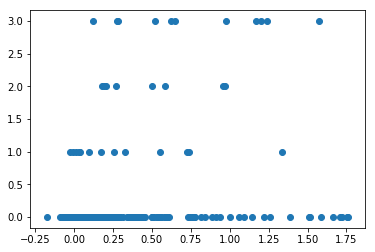

,Feature,Gain
1,RATING_BALL_WINNING,0.202716
6,RATING_SHOTS,0.164676
0,RATING_BALL_USE,0.140784
2,RATING_DEFENCE,0.134085
5,RATING_PRESSURE,0.131782
3,RATING_FIELD_KICKS,0.120685
4,RATING_HITOUTS,0.105272


In [565]:
##Check Results and Feature Importance
#Scatter plot of predictions vs actuals
testing_df = get_testing_df(X_test_ratings_20,y_test_ratings_20,player_ratings_model_20)
plt.scatter(testing_df['preds'],testing_df['actuals'])
#Check MAE
print(mean_absolute_error(testing_df['preds'],testing_df['actuals']))
plt.show()

#Top 10 Features
feature_imp_df = get_feature_imp_df(player_comb_ratings_20_df,player_ratings_model_20)
feature_imp_df[0:10]

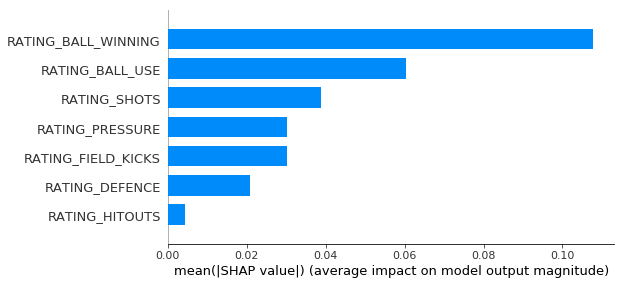

In [566]:
# explain the model's predictions using SHAP
shap_values, X_df = get_shap_imp_df(player_comb_ratings_20_df,X_train_ratings_20,player_ratings_model_20)
shap.summary_plot(shap_values, X_df, plot_type="bar")

In [ ]:
###################################
###################################
############TEAM MODELS############
###################################
###################################

In [494]:
team_18_df = create_team_modelling_df(team_summary_18_df)
X_train_t18, X_test_t18, y_train_t18, y_test_t18 = split_scale_dataset(team_18_df)
team_model_18 = grid_search_cv_model(X_train_t18,y_train_t18)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  5.5min finished


[20:08:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.6019830254527556


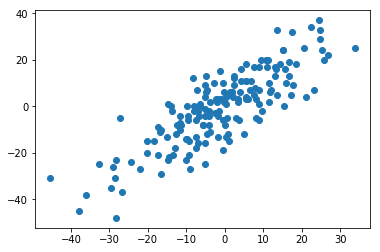

,Feature,Gain
199,CHAIN_METRES_NET,0.158408
161,TIME_IN_POSS_DIFF,0.136437
168,TOTAL_GAINED_METRES,0.027651
94,KICK_GAIN_METRES,0.022585
164,TIME_IN_POSS_SQUAD,0.019327
163,TIME_IN_POSS_OPP_SQUAD,0.014922
246,METRES_GAINED_EFF,0.014883
248,METRES_GAINED_RETAINED,0.013498
195,CHAIN_METRES,0.013453
71,IN50_KICK_RETAIN,0.011010


In [721]:
##Check Results and Feature Importance
#Scatter plot of predictions vs actuals
testing_df = get_testing_df(X_test_t18,y_test_t18,team_model_18)
plt.scatter(testing_df['preds'],testing_df['actuals'])
#Check R2
print(r2_score(testing_df['preds'],testing_df['actuals']))
plt.show()

#Top 10 Features
feature_imp_df = get_feature_imp_df(team_18_df,team_model_18)
feature_imp_df[0:10]

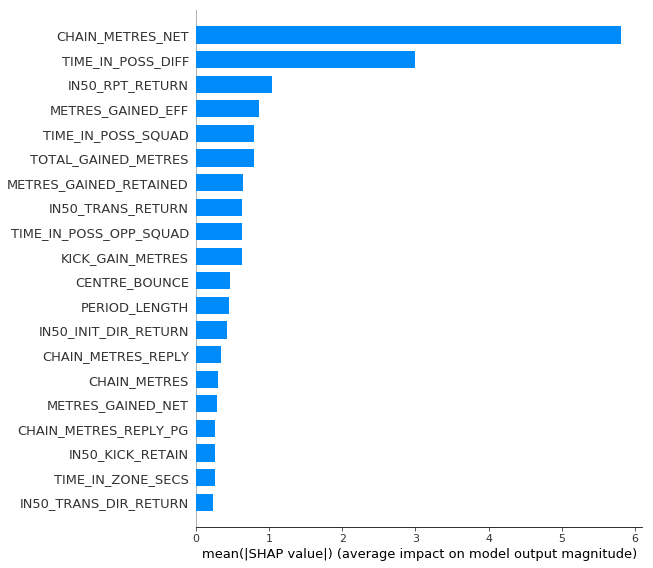

In [722]:
# explain the model's predictions using SHAP
shap_values, X_df = get_shap_imp_df(team_18_df,X_train_t18,team_model_18)
shap.summary_plot(shap_values, X_df, plot_type="bar")

In [496]:
team_19_df = create_team_modelling_df(team_summary_19_df)
X_train_t19, X_test_t19, y_train_t19, y_test_t19 = split_scale_dataset(team_19_df)
team_model_19 = grid_search_cv_model(X_train_t19,y_train_t19)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  5.2min finished


[20:13:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.5599583795935252


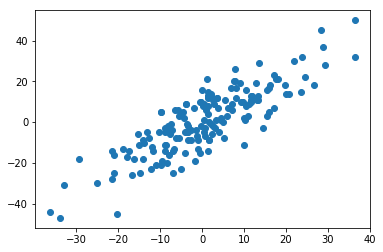

,Feature,Gain
161,TIME_IN_POSS_DIFF,0.149982
199,CHAIN_METRES_NET,0.136337
164,TIME_IN_POSS_SQUAD,0.023611
195,CHAIN_METRES,0.023269
168,TOTAL_GAINED_METRES,0.022083
247,METRES_GAINED_NET,0.016588
127,RE50_RESULT_OTHER,0.015108
207,CHAIN_METRES_REPLY,0.011440
163,TIME_IN_POSS_OPP_SQUAD,0.010316
248,METRES_GAINED_RETAINED,0.009698


In [724]:
##Check Results and Feature Importance
#Scatter plot of predictions vs actuals
testing_df = get_testing_df(X_test_t19,y_test_t19,team_model_19)
plt.scatter(testing_df['preds'],testing_df['actuals'])
#Check R2
print(r2_score(testing_df['preds'],testing_df['actuals']))
plt.show()

#Top 10 Features
feature_imp_df = get_feature_imp_df(team_19_df,team_model_19)
feature_imp_df[0:10]

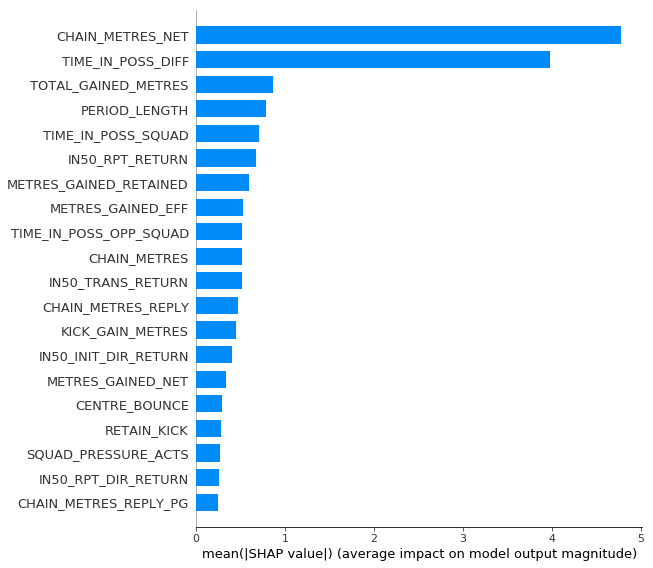

In [725]:
# explain the model's predictions using SHAP
shap_values, X_df = get_shap_imp_df(team_19_df,X_train_t19,team_model_19)
shap.summary_plot(shap_values, X_df, plot_type="bar")

In [498]:
team_20_df = create_team_modelling_df(team_summary_20_df)
X_train_t20, X_test_t20, y_train_t20, y_test_t20 = split_scale_dataset(team_20_df)
team_model_20 = grid_search_cv_model(X_train_t20,y_train_t20)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  3.9min finished


[20:17:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.6761623336336404


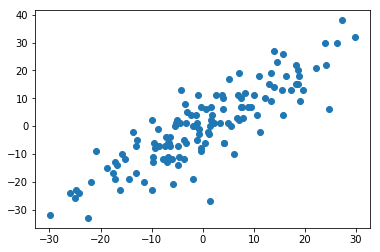

,Feature,Gain
199,CHAIN_METRES_NET,0.142703
164,TIME_IN_POSS_SQUAD,0.072580
161,TIME_IN_POSS_DIFF,0.067964
247,METRES_GAINED_NET,0.062343
168,TOTAL_GAINED_METRES,0.059285
163,TIME_IN_POSS_OPP_SQUAD,0.040195
94,KICK_GAIN_METRES,0.017961
207,CHAIN_METRES_REPLY,0.014071
234,IN50_RPT_RETURN,0.011050
195,CHAIN_METRES,0.011021


In [727]:
##Check Results and Feature Importance
#Scatter plot of predictions vs actuals
testing_df = get_testing_df(X_test_t20,y_test_t20,team_model_20)
plt.scatter(testing_df['preds'],testing_df['actuals'])
#Check R2
print(r2_score(testing_df['preds'],testing_df['actuals']))
plt.show()

#Top 10 Features
feature_imp_df = get_feature_imp_df(team_20_df,team_model_20)
feature_imp_df[0:10]

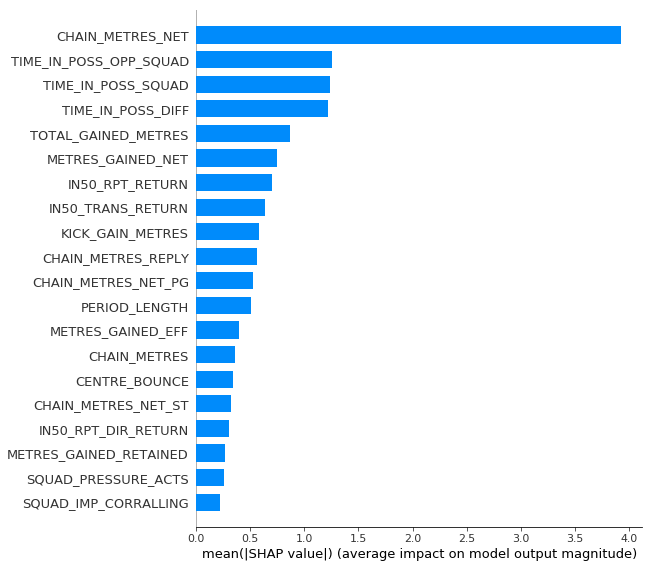

In [728]:
# explain the model's predictions using SHAP
shap_values, X_df = get_shap_imp_df(team_20_df,X_train_t20,team_model_20)
shap.summary_plot(shap_values, X_df, plot_type="bar")

In [729]:
#Get full predictions to write to file
X_full_18 = team_18_df.iloc[:,:-1].values
y_full_18 = team_18_df.iloc[:,-1].values
X_full_19 = team_19_df.iloc[:,:-1].values
y_full_19 = team_19_df.iloc[:,-1].values
X_full_20 = team_20_df.iloc[:,:-1].values
y_full_20 = team_20_df.iloc[:,-1].values

full_df_18 = get_testing_df(X_full_18,y_full_18,team_model_18)
full_df_19 = get_testing_df(X_full_19,y_full_19,team_model_19)
full_df_20 = get_testing_df(X_full_20,y_full_20,team_model_20)

full_df_18.index = team_18_df.index
full_df_19.index = team_19_df.index
full_df_20.index = team_20_df.index

full_df_18.to_csv("AFL-2020-Hackathon/afl_team_preds_2018.csv")
full_df_19.to_csv("AFL-2020-Hackathon/afl_team_preds_2019.csv")
full_df_20.to_csv("AFL-2020-Hackathon/afl_team_preds_2020.csv")

In [730]:
#Write Shap values to file
shap_values_18, X_df_18 = get_shap_imp_df(team_18_df,X_train_t18,team_model_18)
shap_values_19, X_df_19 = get_shap_imp_df(team_19_df,X_train_t19,team_model_19)
shap_values_20, X_df_20 = get_shap_imp_df(team_20_df,X_train_t20,team_model_20)

shap_df_18 = pd.DataFrame(shap_values_18, columns=team_18_df.columns[:-1], index=X_train_t18.index)
shap_df_19 = pd.DataFrame(shap_values_19, columns=team_19_df.columns[:-1], index=X_train_t19.index)
shap_df_20 = pd.DataFrame(shap_values_20, columns=team_20_df.columns[:-1], index=X_train_t20.index)

shap_df_18.to_csv("AFL-2020-Hackathon/teams_shap_18.csv")
shap_df_19.to_csv("AFL-2020-Hackathon/teams_shap_19.csv")
shap_df_20.to_csv("AFL-2020-Hackathon/teams_shap_20.csv")

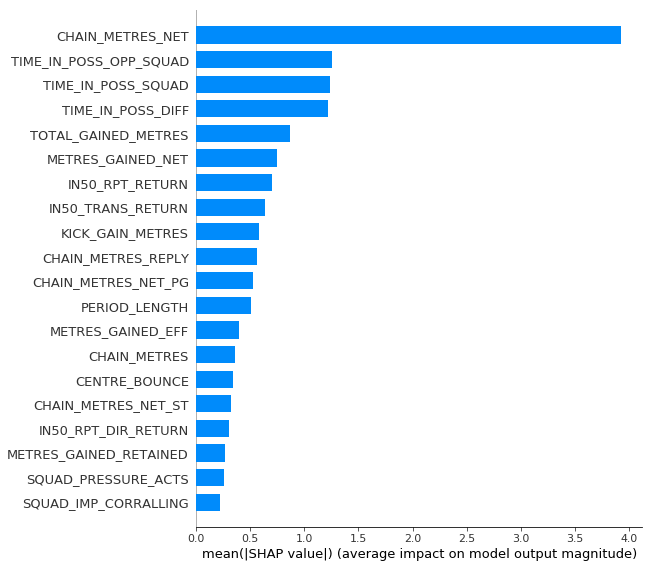

In [736]:
shap_plot = shap.summary_plot(shap_values, X_df, plot_type="bar")